Himani Parikh - 1322085

CSCI 636 - Big Data Analytics

Hands on 12.1 : Weather	Pattern	Clustering using k-mean in Spark
Learning	Goals

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=a41c27d9e60a50032b482325a5c3465f51a3e863fe12848399c0e1274e6a1ea2
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .master('local[*]')\
        .getOrCreate()
sc = spark.sparkContext

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change the directory to big-data-colab folder
%cd /content/drive/My Drive/Colab Notebooks/BigDataColabHimaniParikh/

#pwd
!ls

/content/drive/My Drive/Colab Notebooks/BigDataColabHimaniParikh
 10.2Spark-ClassificationHimani-Quiz.ipynb	    'Hands On 9.2-Himani.ipynb'
 10.Spark-ClassificationHimani.ipynb		     out
 11.2.Spark-Classifier-evaluationHimani-Quiz.ipynb   out_Datajoin
 11.Spark-Classifier-evaluationHimani.ipynb	     outDatajoin2
 2.DataCopyHimani.ipynb				     out_grep
 2_WordCountHimani.ipynb			     out_testfile
 3.1_WordGrepHimani.ipynb			     out_testfile1
 3.2_WordMedianHimani.ipynb			     out_testfile2
 4.MR-DataJoinHimani.ipynb			     out_wordmedian
 4.MR-WordCountHimani.ipynb			     Prediction
 5.MR-DataJoin2Himani.ipynb			     Project
 6.MR-WordCountReducerHimani.ipynb		     SparkOutput
 7.Spark-WordCountHimani.ipynb			     SqlDataSet
 8.Spark-SQLHimani.ipynb			     testfile1
 8.Spark-StreamingHimani.ipynb			     testfile2
 9.Spark-Handling-missing-values-Himani.ipynb	     WeatherDataset
 BigDataHimani.ipynb				     wordcount_mapper.py
 Data						     wordcount_num0_output.txt
 Data-Cluster			

In [ ]:
# change the directory to big-data-colab folder
%cd /content/drive/My Drive/Colab Notebooks/BigDataColabHimaniParikh/Data-Cluster

#pwd
!ls

/content/drive/My Drive/Colab Notebooks/BigDataColabHimaniParikh/Data-Cluster
minute_weather.csv  utils.py


In [ ]:
!cp utils.py /content/utils.py

In [ ]:
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
import utils

%matplotlib inline

In [ ]:
sqlsc = SQLContext(sc)

df = sqlsc.read.load('/content/drive/My Drive/Colab Notebooks/BigDataColabHimaniParikh/Data-Cluster/minute_weather.csv',
                     format='com.databricks.spark.csv',
                     header='true',
                     inferSchema='true')


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


***Subset and remove unused data***

In [ ]:
df.count()

1587257

In [ ]:
filteredDf = df.filter((df.rowID % 10) == 0) # 10th, 2oth, 30th
filteredDf.count()

158726

In [ ]:
filteredDf.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
air_pressure,158726,916.830161410252,3.051716552831359,905.0,929.5
air_temp,158726,61.85158915363659,11.833569210641672,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905958,0.0,359.0
avg_wind_speed,158680,2.7752148979077376,2.0576239697426337,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.452138538387,0.0,359.0
max_wind_speed,158680,3.4005577262415194,2.4188016208098855,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784576,0.0,359.0
min_wind_speed,158680,2.1346641038569323,1.7421125052424373,0.0,31.6


In [ ]:
filteredDf.filter(filteredDf.rain_accumulation == 0.0).count()

157812

In [ ]:
filteredDf.filter(filteredDf.rain_duration == 0.0).count()

157237

In [ ]:
workingDf = filteredDf.drop("rain_accumulation").drop("rain_duration"). drop("hpwren_timestamp")

In [ ]:
before = workingDf.count()
workingDf = workingDf.na.drop()
after = workingDf.count()
before - after

46

***Scale the data***

In [ ]:
workingDf.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

In [ ]:
featuresUsed = [
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'relative_humidity']

assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDf)

In [ ]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

***Create elbow plot***

In [ ]:
scaledData = scaledData.select("features", "rowID")
elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()

DataFrame[features: vector]

In [ ]:
clusters = range(2,31)
wsseList = utils.elbow(elbowset, clusters)

Training for cluster size 2 
......................WSSE = 117228.9979233905 
Training for cluster size 3 
......................WSSE = 103495.35420742206 
Training for cluster size 4 
......................WSSE = 94586.68234188115 
Training for cluster size 5 
......................WSSE = 91139.2667956011 
Training for cluster size 6 
......................WSSE = 85087.2210236736 
Training for cluster size 7 
......................WSSE = 81832.63278657752 
Training for cluster size 8 
......................WSSE = 79377.41489112313 
Training for cluster size 9 
......................WSSE = 76637.98160500702 
Training for cluster size 10 
......................WSSE = 74021.78447395912 
Training for cluster size 11 
......................WSSE = 73935.48341630568 
Training for cluster size 12 
......................WSSE = 69819.66134223137 
Training for cluster size 13 
......................WSSE = 68848.32891230956 
Training for cluster size 14 
......................WSSE = 67627.48956805

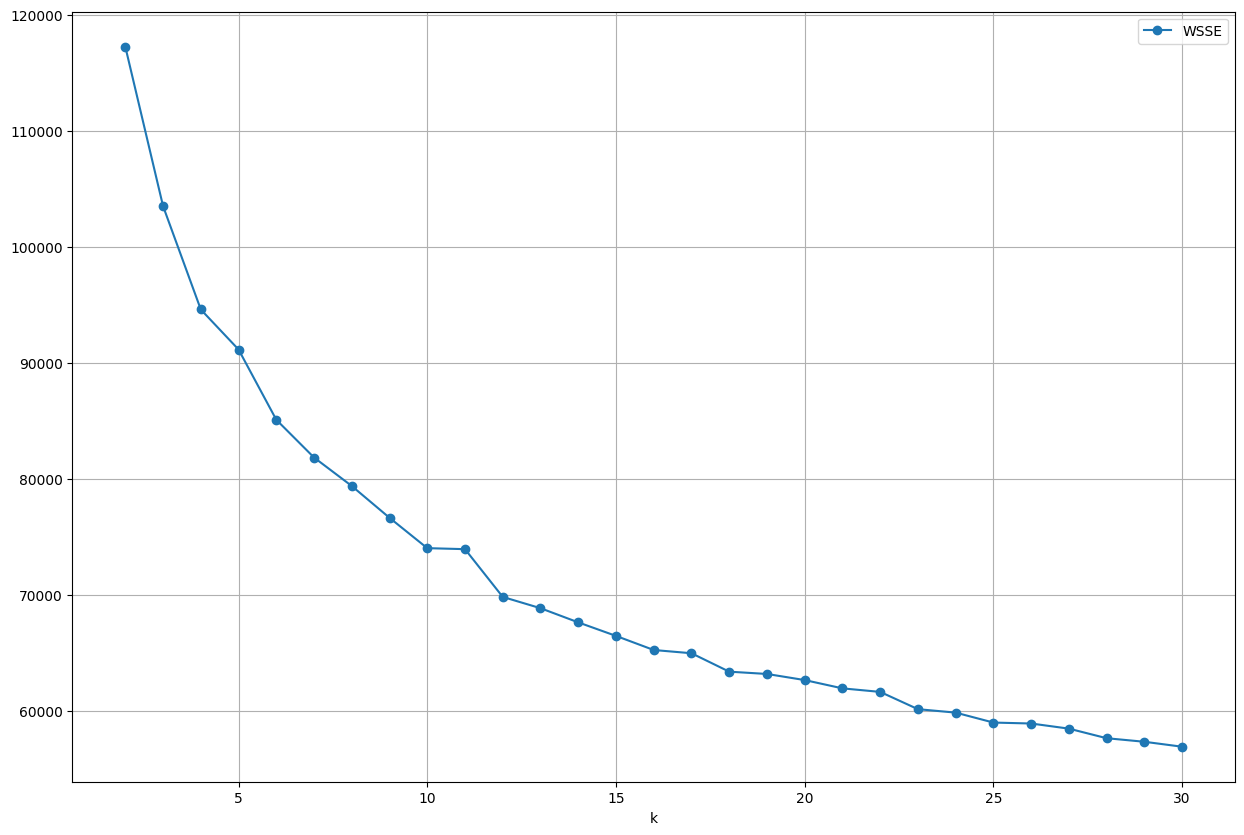

In [ ]:
utils.elbow_plot(wsseList, clusters)

***Cluster using selected K***

In [ ]:
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

In [ ]:
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [ ]:
centers = model.clusterCenters()
centers

[array([ 0.31193071, -1.10515968, -1.20684724, -0.5740194 , -1.03920901,
        -0.57936301,  1.07993424]),
 array([ 0.23351408,  0.32066637,  1.88802599, -0.65182056, -1.55151455,
        -0.57651829, -0.2838673 ]),
 array([ 0.30948763,  0.75917911,  1.32559394, -0.63411172,  1.58966255,
        -0.58502263, -0.73899788]),
 array([-0.4338757 ,  0.11613187, -1.17258135, -0.56598772, -1.0498596 ,
        -0.59604043,  0.13662035]),
 array([ 1.44246571, -0.12062683, -1.10201792, -0.09949119, -0.96071048,
        -0.07920465, -0.98449415]),
 array([-1.16139016, -0.83731699,  0.44626299,  1.99066016,  0.5364939 ,
         1.94811864,  0.88038539]),
 array([-0.17202135,  0.61782603,  0.4090396 ,  0.65260512,  0.51893837,
         0.59598055, -0.17946092]),
 array([ 1.18470473, -0.24914106, -1.15442856,  2.09796054, -1.05220352,
         2.21392217, -1.13276907]),
 array([-0.88341971, -1.17891884,  0.37201834,  0.38661636,  0.47274197,
         0.37361112,  1.34268906]),
 array([-0.23216221

***Create parallel plots of clusters and analysis***

In [ ]:
P = utils.pd_centers(featuresUsed, centers)

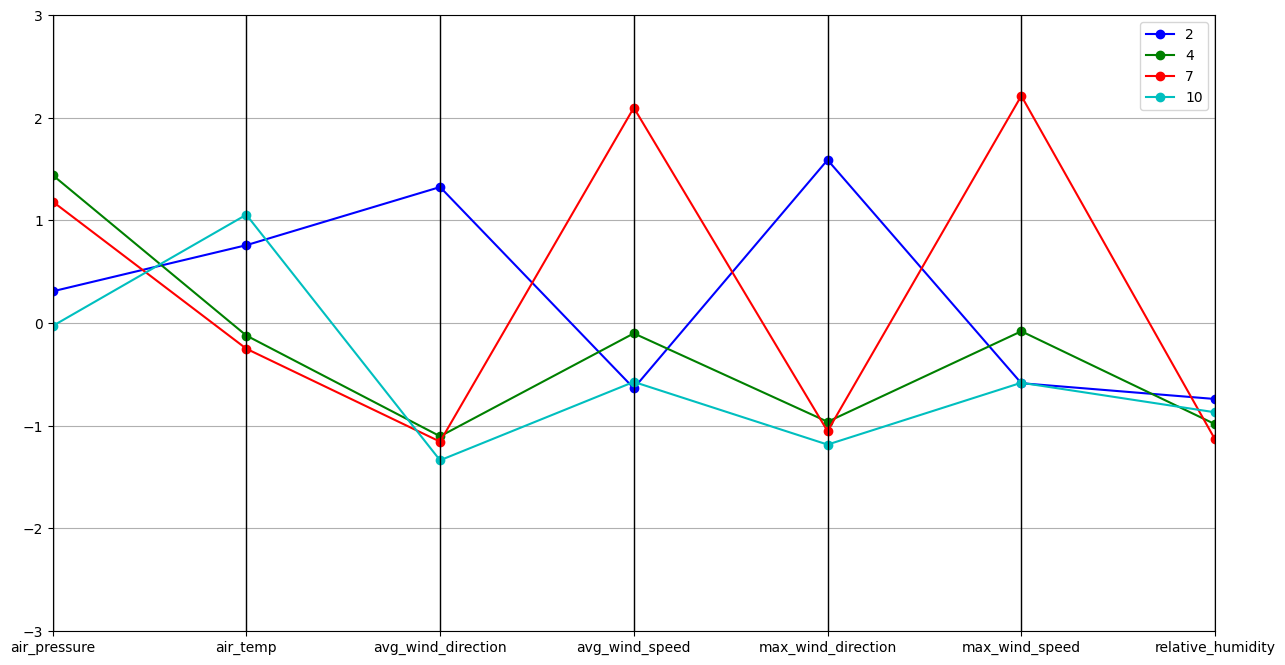

In [ ]:
utils.parallel_plot(P[P['relative_humidity'] < -0.5], P)

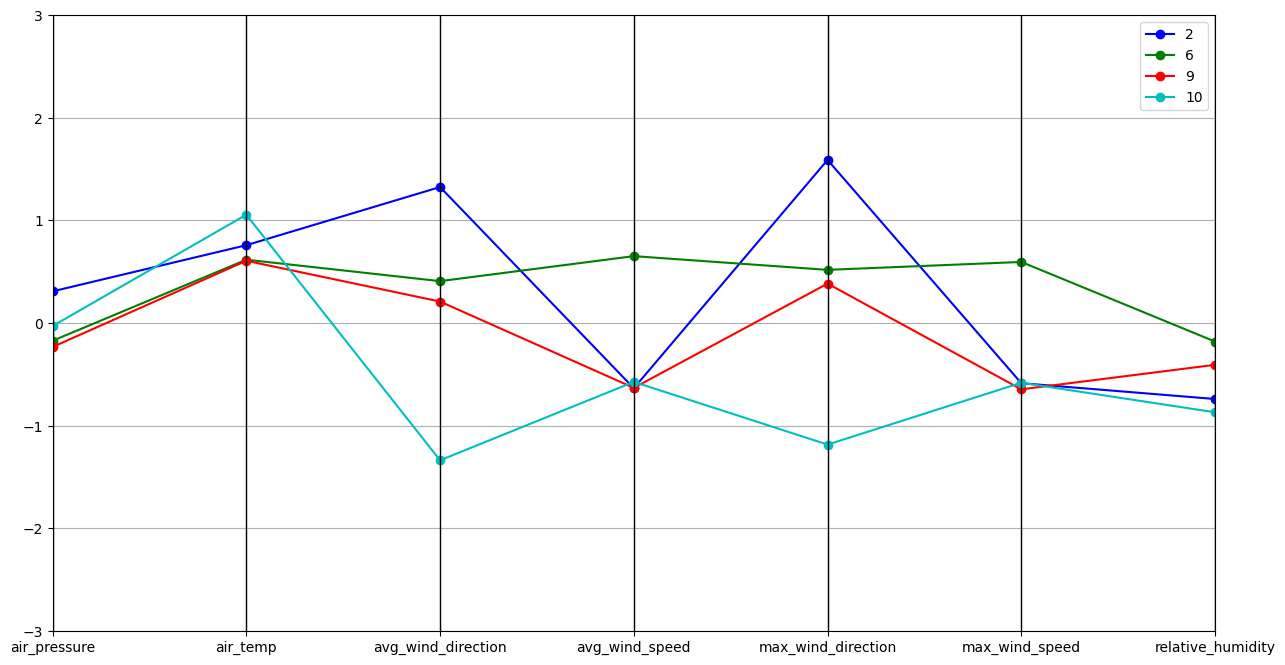

In [ ]:
utils.parallel_plot(P[P['air_temp'] > 0.5], P)

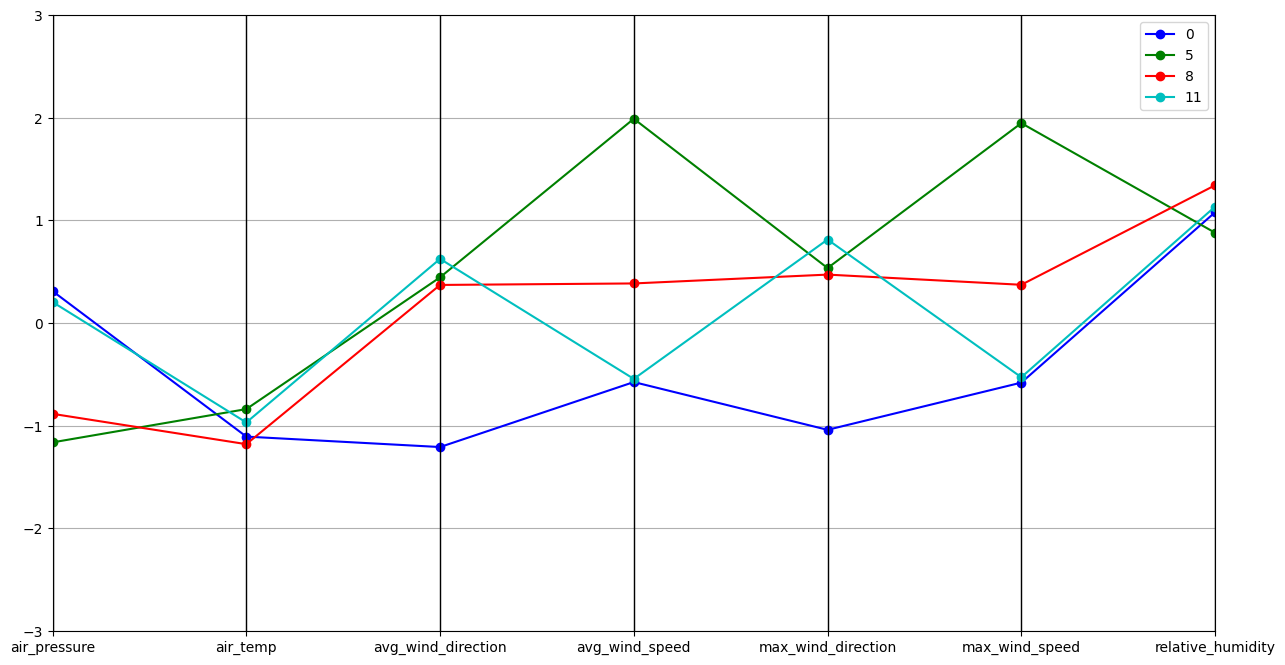

In [ ]:
utils.parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)] , P)

***Other days***

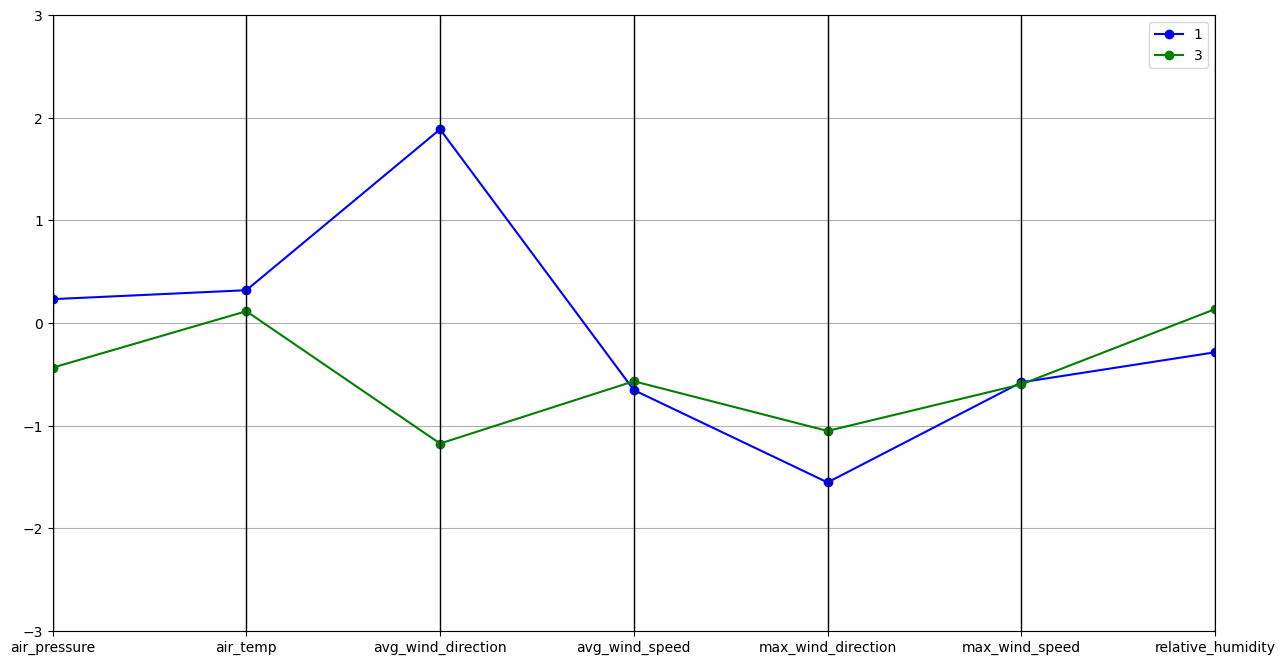

In [ ]:
utils.parallel_plot(P.iloc[[1,3]], P)